# Home Credit Default Risk Prediction (Kaggle)

This project is focused on predicting the ability of loan applicants to reimburse lenders, as part of the Home Credit Default Risk challenge on Kaggle. The goal is to use various machine learning techniques to forecast whether applicants will be able to repay a loan. This notebook covers data loading, cleaning, exploratory data analysis, feature engineering, model training, and evaluation.


## Dependencies

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels
from imblearn.over_sampling import SMOTE
from scipy.stats import randint as sp_randint
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score, roc_curve
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, PolynomialFeatures, StandardScaler
from xgboost import XGBClassifier
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.4f' % x)
sns.set(style="whitegrid")

## Data Loading, Cleaning & Preprocessing

In [2]:
# Load datasets
train = pd.read_csv('application_train.csv')
prev = pd.read_csv('previous_application.csv')
pos_cash = pd.read_csv('POS_CASH_balance.csv')

# Function for preprocessing datasets
def preprocess_data(df):
    
    # Numeric features: Median imputation
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].median())

    # Categorical features: Mode imputation
    categorical_cols = df.select_dtypes(include=['object']).columns
    df[categorical_cols] = df[categorical_cols].fillna(df[categorical_cols].mode().iloc[0])

    # Encoding categorical variables
    le = LabelEncoder()
    for col in categorical_cols:
        df[col] = le.fit_transform(df[col].astype(str))
    return df

# Apply preprocessing to each dataset
train = preprocess_data(train)
prev = preprocess_data(prev)
pos_cash = preprocess_data(pos_cash)

print(f'Processed main dataset shape: {train.shape}')
print(f'Processed previous application dataset shape: {prev.shape}')
print(f'Processed POS CASH balance dataset shape: {pos_cash.shape}')

Processed main dataset shape: (307511, 122)
Processed previous application dataset shape: (1670214, 37)
Processed POS CASH balance dataset shape: (10001358, 8)


In [3]:
# Define aggregation methods for numeric and categorical columns
def aggregate_numeric(df, group_var, df_name):
    """Aggregate the numeric columns of a dataframe. This can
    be used to create features for each instance of the grouping variable."""
    
    # Remove id variables other than grouping variable
    for col in df:
        if col != group_var and 'SK_ID' in col:
            df = df.drop(columns = col)
            
    group_ids = df[group_var]
    numeric_df = df.select_dtypes('number')
    numeric_df[group_var] = group_ids

    # Aggregate the numeric columns
    agg = numeric_df.groupby(group_var).agg(['count', 'mean', 'max', 'min', 'sum']).reset_index()
    
    # Need to create new column names
    columns = [group_var]
    for var in agg.columns.levels[0]:
        if var != group_var:
            for stat in agg.columns.levels[1][:-1]:
                columns.append(f'{df_name}_{var}_{stat}')
    agg.columns = columns
    return agg

def aggregate_categorical(df, group_var, df_name):
    """Aggregate the categorical columns of a dataframe. This can
    be used to create features for each instance of the grouping variable."""
    
    # Check if there are categorical columns
    categorical_cols = df.select_dtypes(include=['object']).columns
    if len(categorical_cols) == 0:
        return pd.DataFrame(columns=[group_var])

    # Select the categorical columns
    categorical = pd.get_dummies(df[categorical_cols])

    # Make sure to put the identifying id on the column
    categorical[group_var] = df[group_var]

    # Group by the group var and calculate the sum and mean
    categorical = categorical.groupby(group_var).agg(['sum', 'mean']).reset_index()

    # Create new column names
    column_names = [group_var]
    for var in categorical.columns.levels[0]:
        if var != group_var:
            for stat in categorical.columns.levels[1]:
                column_names.append(f'{df_name}_{var}_{stat}')
    categorical.columns = column_names

    return categorical


# Aggregate the previous_application dataset
prev_agg = aggregate_numeric(prev, 'SK_ID_CURR', 'prev')
prev_agg_cat = aggregate_categorical(prev, 'SK_ID_CURR', 'prev')
prev_agg = prev_agg.merge(prev_agg_cat, on = 'SK_ID_CURR', how = 'outer')

# Aggregate the POS_CASH_balance dataset
pos_cash_agg = aggregate_numeric(pos_cash, 'SK_ID_CURR', 'pos_cash')
pos_cash_agg_cat = aggregate_categorical(pos_cash, 'SK_ID_CURR', 'pos_cash')
pos_cash_agg = pos_cash_agg.merge(pos_cash_agg_cat, on = 'SK_ID_CURR', how = 'outer')

# Merge the aggregated data with the training data
train = train.merge(prev_agg, on = 'SK_ID_CURR', how = 'left')
train = train.merge(pos_cash_agg, on = 'SK_ID_CURR', how = 'left')

print(f'Final dataset shape: {train.shape}')


Final dataset shape: (307511, 327)


In [4]:
# Calculate the percentage of rows with missing values
total_rows = train.shape[0]
rows_with_missing = train.isnull().any(axis=1).sum()
percentage_missing = (rows_with_missing / total_rows) * 100

print(f"Total rows: {total_rows}")
print(f"Rows with missing values: {rows_with_missing}")
print(f"Percentage of rows with missing values: {percentage_missing:.2f}%")


Total rows: 307511
Rows with missing values: 19234
Percentage of rows with missing values: 6.25%


In [5]:
# Very low portion of rows have missing values, remove them for now
train = train.dropna()


## Exploratory Data Analysis (EDA)
Here we perform an exploratory analysis to understand our data better and inform our feature engineering and modeling choices.

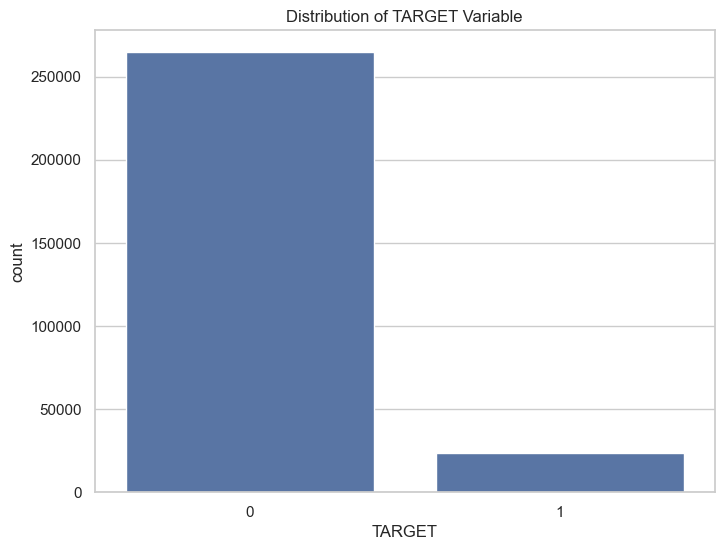

Percentage of Class 0 (No Default): 91.84%
Percentage of Class 1 (Default): 8.16%


In [6]:
# Analyzing the Target Variable
plt.figure(figsize=(8, 6))
sns.countplot(x='TARGET', data=train)
plt.title('Distribution of TARGET Variable')
plt.show()
target_counts = train['TARGET'].value_counts(normalize=True) * 100
print("Percentage of Class 0 (No Default): {:.2f}%".format(target_counts[0]))
print("Percentage of Class 1 (Default): {:.2f}%".format(target_counts[1]))

In [7]:
# Calculating correlations with the target variable
correlations = train.corr()['TARGET'].sort_values()

# Displaying the most positively and negatively correlated features
print('Most Positive Correlations:\n', correlations.tail(10))
print('\nMost Negative Correlations:\n', correlations.head(10))

Most Positive Correlations:
 CODE_GENDER                            0.0568
prev_NAME_CONTRACT_STATUS_sum          0.0575
REGION_RATING_CLIENT                   0.0581
DAYS_LAST_PHONE_CHANGE                 0.0601
REGION_RATING_CLIENT_W_CITY            0.0604
prev_NAME_CONTRACT_STATUS_mean         0.0711
DAYS_BIRTH                             0.0811
TARGET                                 1.0000
FLAG_MOBIL                                NaN
prev_FLAG_LAST_APPL_PER_CONTRACT_max      NaN
Name: TARGET, dtype: float64

Most Negative Correlations:
 EXT_SOURCE_2                      -0.1592
EXT_SOURCE_3                      -0.1544
EXT_SOURCE_1                      -0.0998
prev_CODE_REJECT_REASON_mean      -0.0700
prev_NAME_YIELD_GROUP_mean        -0.0535
prev_CODE_REJECT_REASON_min       -0.0513
DAYS_EMPLOYED                     -0.0464
prev_DAYS_FIRST_DRAWING_min       -0.0422
prev_NAME_CASH_LOAN_PURPOSE_min   -0.0401
prev_NAME_CLIENT_TYPE_min         -0.0393
Name: TARGET, dtype: float64


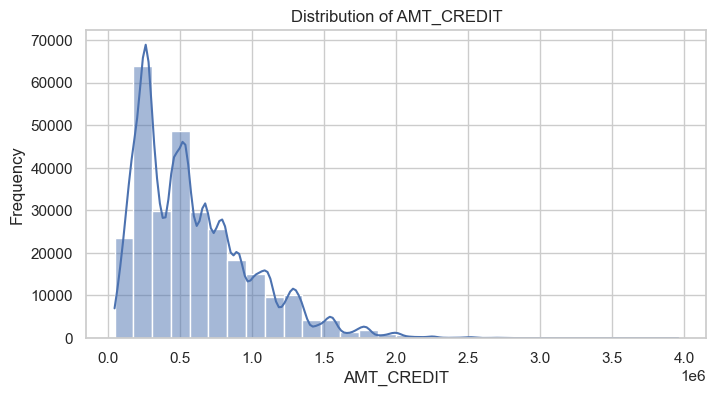

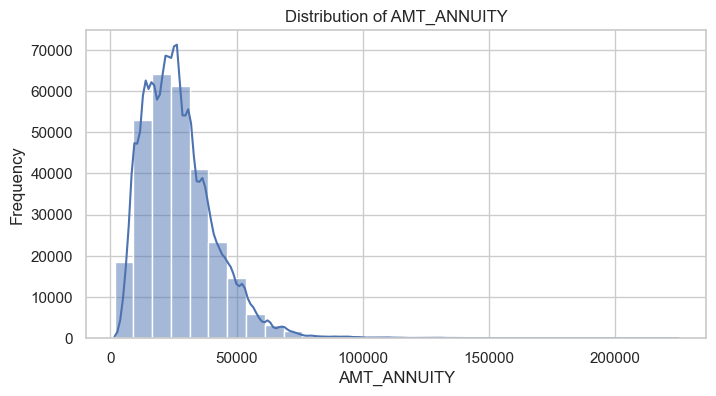

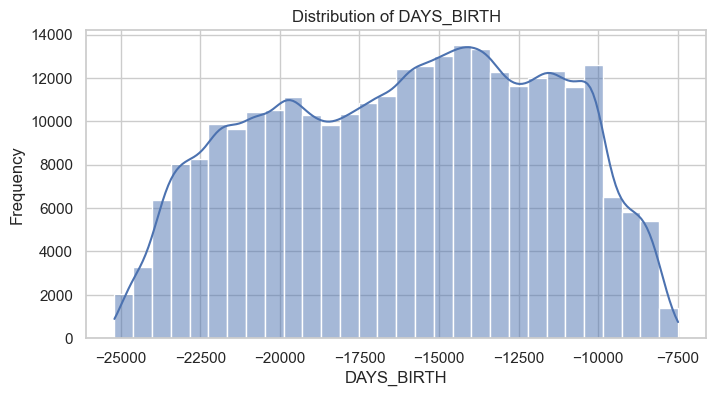

In [8]:
# key numerical features for analysis
numerical_features = ['AMT_CREDIT', 'AMT_ANNUITY', 'DAYS_BIRTH']

# Plotting the distributions
for feature in numerical_features:
    plt.figure(figsize=(8, 4))
    sns.histplot(train[feature], kde=True, bins=30)
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')


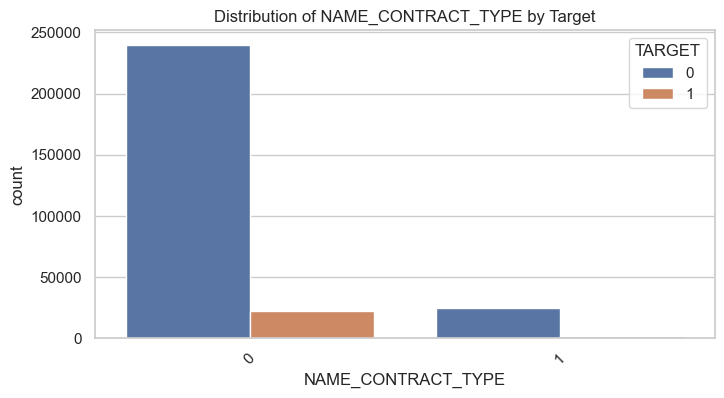

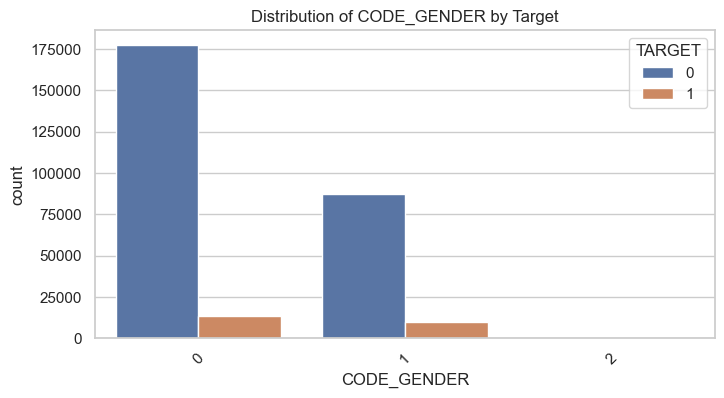

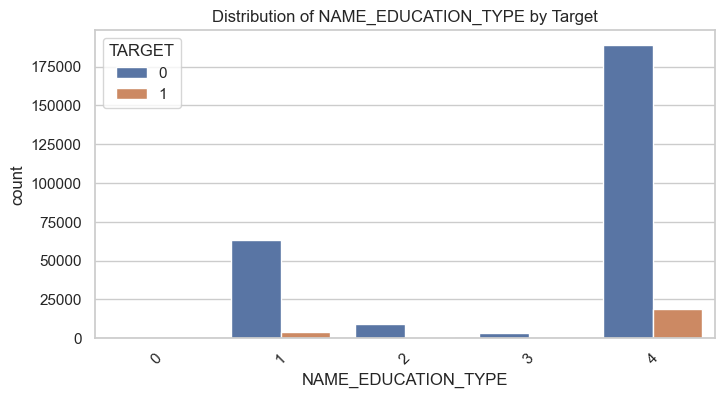

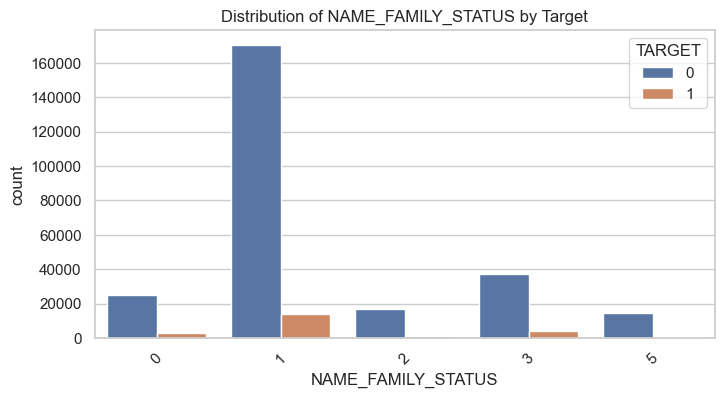

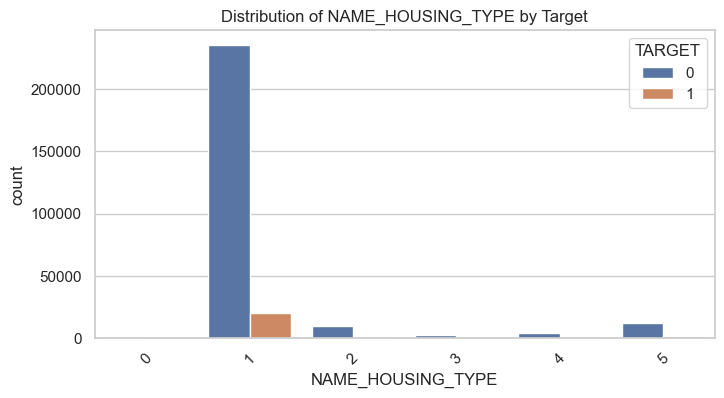

In [9]:
categorical_features = ['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE']

for feature in categorical_features:
    plt.figure(figsize=(8, 4))
    sns.countplot(x=feature, hue='TARGET', data=train)
    plt.title(f'Distribution of {feature} by Target')
    plt.xticks(rotation=45)
    plt.show()


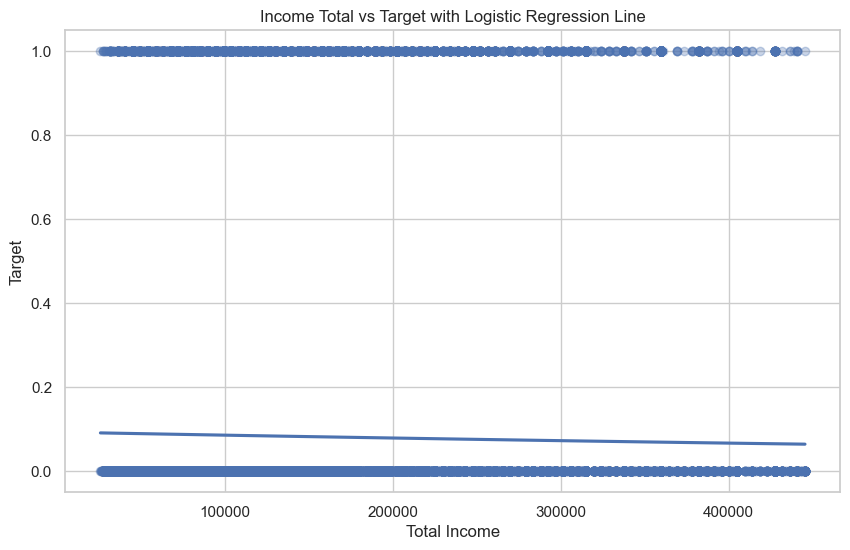

In [11]:
# Filtering out the extreme outlier for a better visualization
max_threshold = train['AMT_INCOME_TOTAL'].quantile(0.99)
train_filtered = train[train['AMT_INCOME_TOTAL'] < max_threshold]

# Creating a scatterplot with a logistic regression line
plt.figure(figsize=(10, 6))
sns.regplot(x='AMT_INCOME_TOTAL', y='TARGET', data=train_filtered, logistic=True, ci=None, scatter_kws={'alpha':0.3})
plt.title('Income Total vs Target with Logistic Regression Line')
plt.xlabel('Total Income')
plt.ylabel('Target')
plt.show()


## Feature Engineering

In [12]:
def feature_engineering(df):
    numerical_features = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
    categorical_features = df.select_dtypes(include=['object', 'category']).columns.tolist()

    for col in categorical_features:
        freqs = df[col].value_counts()
        df[col] = np.where(df[col].isin(freqs.index[freqs >= 0.20 * len(df)]), df[col], 'Other')

    df = pd.get_dummies(df, columns=categorical_features, drop_first=True)

    selected_features_for_poly = ['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'CNT_CHILDREN', 'CNT_FAM_MEMBERS']
    poly = PolynomialFeatures(degree=2, include_bias=False)
    df_poly = poly.fit_transform(df[selected_features_for_poly])
    df_poly = pd.DataFrame(df_poly, columns=poly.get_feature_names_out(selected_features_for_poly))
    
    # Drop original numerical features before merging
    df = df.drop(columns=selected_features_for_poly)

    df = df.reset_index(drop=True)
    df = pd.concat([df, df_poly], axis=1)

    df['INCOME_x_CREDIT'] = df['AMT_INCOME_TOTAL'] * df['AMT_CREDIT']
    df['AGE_x_EMPLOYMENT'] = (df['DAYS_BIRTH'] / -365) * (df['DAYS_EMPLOYED'] / -365)
    df['INCOME_PER_FAMILY_MEMBER'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['CREDIT_x_ANNUITY'] = df['AMT_CREDIT'] * df['AMT_ANNUITY']
    df['INCOME_x_AGE'] = df['AMT_INCOME_TOTAL'] * (df['DAYS_BIRTH'] / -365)
    df['EMPLOYMENT_x_CREDIT'] = (df['DAYS_EMPLOYED'] / -365) * df['AMT_CREDIT']
    for ext_source in ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']:
        df[f'AGE_x_{ext_source}'] = (df['DAYS_BIRTH'] / -365) * df[ext_source]
    df['CHILDREN_x_ANNUITY'] = df['CNT_CHILDREN'] * df['AMT_ANNUITY']
    df['FAMILY_MEMBERS_x_CREDIT'] = df['CNT_FAM_MEMBERS'] * df['AMT_CREDIT']
    df['INCOME_x_OWN_CAR_AGE'] = df['AMT_INCOME_TOTAL'] * df['OWN_CAR_AGE']
    df['CREDIT_x_GOODS_PRICE'] = df['AMT_CREDIT'] * df['AMT_GOODS_PRICE']
    df['ANNUITY_x_GOODS_PRICE'] = df['AMT_ANNUITY'] * df['AMT_GOODS_PRICE']

    return df


In [13]:
train_transformed = feature_engineering(train)

In [14]:
# Check for missing values in each column
missing_values = train_transformed.isnull().sum()
missing_percent = (missing_values / len(train_transformed)) * 100

# Display columns with missing values and their percentage
missing_df = pd.DataFrame({'Missing Values': missing_values, 'Percent': missing_percent})
missing_df = missing_df[missing_df['Missing Values'] > 0].sort_values(by='Percent', ascending=False)
missing_df

,Missing Values,Percent


## Model Training

In [15]:
train_transformed.shape

(288277, 370)

### Random Forest

In [16]:
X = train_transformed.drop('TARGET', axis=1)
y = train_transformed['TARGET']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=11)
rf = RandomForestClassifier(class_weight='balanced')
rf.fit(X_train, y_train)

importances = rf.feature_importances_
indices = np.argsort(importances)[-100:]  # Selecting top 100 features
X_train_selected = X_train.iloc[:, indices]
X_test_selected = X_test.iloc[:, indices]

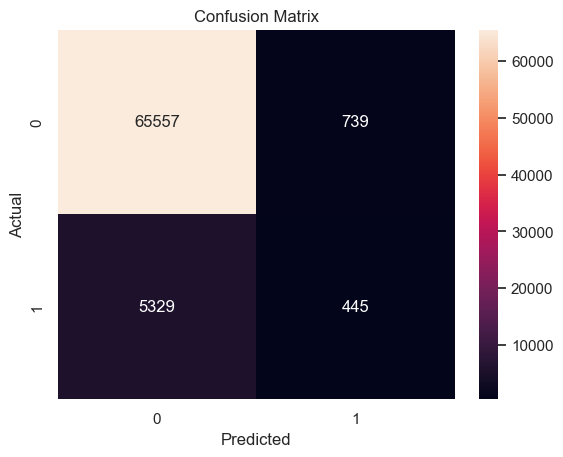

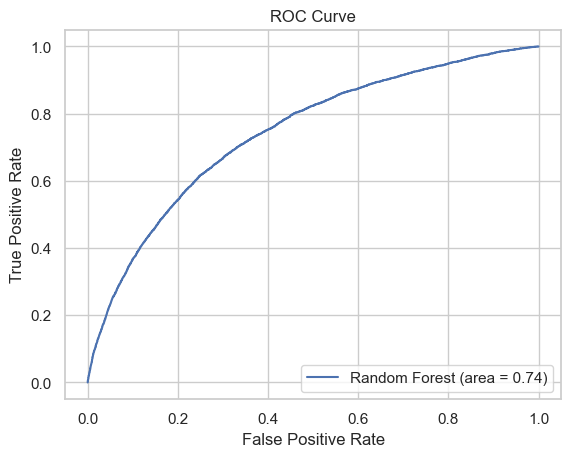

CPU times: user 11min 5s, sys: 387 ms, total: 11min 5s
Wall time: 11min 5s


In [17]:
%%time
# Calculate custom class weights
class_weight = {
    0: 1,  # Weight for class 0
    1: 15  # Increase weight for class 1
}

# Initialize the model with custom class weights
rf_final = RandomForestClassifier(
    n_estimators=500, 
    min_samples_split=2,
    min_samples_leaf=6, 
    max_features='sqrt', 
    max_depth=50,  
    bootstrap=True, 
    class_weight=class_weight
)

# Fit and predict as before
rf_final.fit(X_train_selected, y_train)
y_pred = rf_final.predict(X_test_selected) 

conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='g')
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

y_pred_proba = rf_final.predict_proba(X_test_selected)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_proba)
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, label=f'Random Forest (area = {roc_auc:.2f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()


### XGBoost

In [18]:
scale_pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]
xgb_model = XGBClassifier(scale_pos_weight=scale_pos_weight)

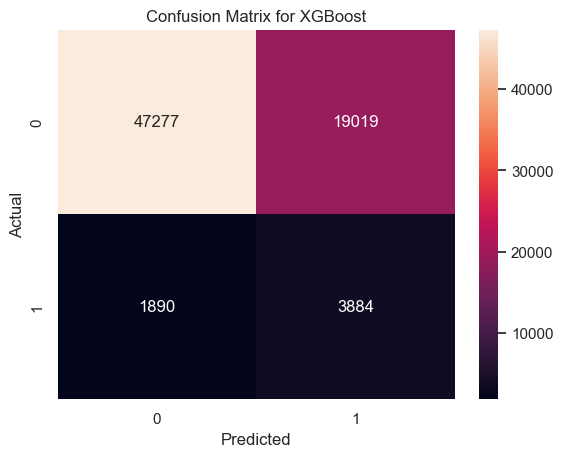

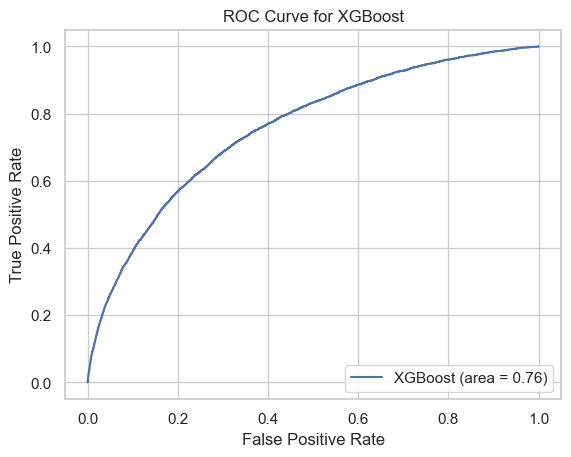

In [19]:
# Train the final model using the best parameters
xgb_final = XGBClassifier(
    subsample=0.7,
    n_estimators=400,
    min_child_weight=4,
    max_depth=4,
    learning_rate=0.05,
    colsample_bytree=0.9,
    scale_pos_weight=scale_pos_weight)
xgb_final.fit(X_train_selected, y_train)

# Make predictions
xgb_predictions = xgb_final.predict(X_test_selected)

# Confusion Matrix
xgb_conf_matrix = confusion_matrix(y_test, xgb_predictions)
sns.heatmap(xgb_conf_matrix, annot=True, fmt='g')
plt.title('Confusion Matrix for XGBoost')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# ROC AUC
xgb_pred_proba = xgb_final.predict_proba(X_test_selected)[:, 1]
xgb_roc_auc = roc_auc_score(y_test, xgb_pred_proba)
xgb_fpr, xgb_tpr, _ = roc_curve(y_test, xgb_pred_proba)
plt.plot(xgb_fpr, xgb_tpr, label=f'XGBoost (area = {xgb_roc_auc:.2f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for XGBoost')
plt.legend(loc='lower right')
plt.show()
